# SMS Spam Collection

to built a model to detect SMS spams

### Import libraries

In [147]:
# importing ...
import seaborn as sns
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, accuracy_score
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [148]:
df =  pd.read_csv('spam.csv', encoding='latin-1')

utf-8 code error usually comes when the range of numeric values exceeding 0 to 127, hence I have added "encoding = -1"

---> https://stackoverflow.com/questions/5552555/unicodedecodeerror-invalid-continuation-byte

In [149]:
df.head(10)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
5,spam,FreeMsg Hey there darling it's been 3 week's n...,NaN,NaN,NaN
6,ham,Even my brother is not like to speak with me. ...,NaN,NaN,NaN
7,ham,As per your request 'Melle Melle (Oru Minnamin...,NaN,NaN,NaN
8,spam,WINNER!! As a valued network customer you have...,NaN,NaN,NaN
9,spam,Had your mobile 11 months or more? U R entitle...,NaN,NaN,NaN


In [150]:
# checking for missing values
df.isnull().sum()

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

In [151]:
#data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [152]:
# Drop unnecessary columns if they exist
df = df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'])

In [153]:
# Rename columns 
df.columns = ['label', 'message']

In [154]:
# shape the dataframe
df.shape

(5572, 2)

In [155]:
# Now we replace the missing values
df['message'].fillna('unknown', inplace=True)
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [180]:
# checking for missing values
df.isnull().sum()

label             0
message           0
message_length    0
dtype: int64

In [157]:
# df.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


### Text Preprocessing

In [158]:
# performing tokenization
df['tokens'] = df['message'].apply(word_tokenize)

In [159]:
# removing stopwords from the message
stop_words = set(stopwords.words('english'))
df['tokens'] = df['tokens'].apply(lambda x: [item for item in x if item.lower() not in stop_words])

In [160]:
# join tokens into a single string
df['tokens'] = df['tokens'].apply(lambda x: ' '.join(x))

In [161]:
df['tokens'] = df['tokens'].apply(lambda x: x.lower())
df.head()

,label,message,tokens
0,ham,"Go until jurong point, crazy.. Available only ...","go jurong point , crazy .. available bugis n g..."
1,ham,Ok lar... Joking wif u oni...,ok lar ... joking wif u oni ...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,u dun say early hor ... u c already say ...
4,ham,"Nah I don't think he goes to usf, he lives aro...","nah n't think goes usf , lives around though"


In [162]:
# creating a function remove the punctuation marks from the text
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]
    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    # Convert text into list of words/tokens
    tokens = nopunc.split()
    return tokens

In [163]:
df['tokens'] = df['tokens'].apply(text_process)

In [164]:
df['message'] = df['tokens'].apply(lambda x: ' '.join(x))
df.head()

,label,message,tokens
0,ham,go jurong point crazy available bugis n great ...,"[go, jurong, point, crazy, available, bugis, n..."
1,ham,ok lar joking wif u oni,"[ok, lar, joking, wif, u, oni]"
2,spam,free entry 2 wkly comp win fa cup final tkts 2...,"[free, entry, 2, wkly, comp, win, fa, cup, fin..."
3,ham,u dun say early hor u c already say,"[u, dun, say, early, hor, u, c, already, say]"
4,ham,nah nt think goes usf lives around though,"[nah, nt, think, goes, usf, lives, around, tho..."


In [165]:
# now drop the tokens column
df = df.drop('tokens', axis=1)

In [166]:
# making sure all messages are strings
df['message'] = df['message'].astype(str)

### Data Visualization

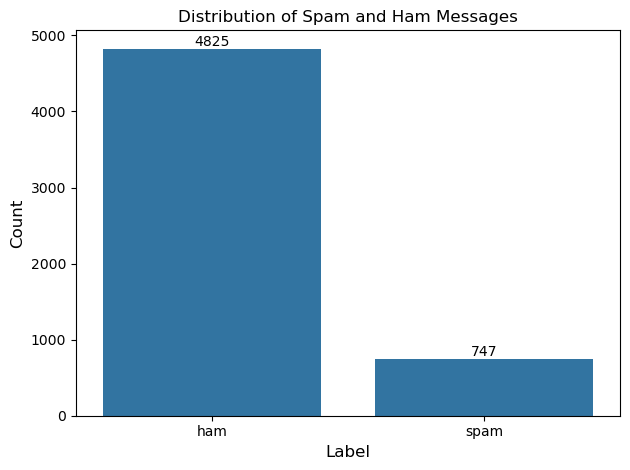

In [193]:
# just showing you the amount of messages for spam and ham

sns.countplot(x='label', data=df)
plt.title('Distribution of Spam and Ham Messages')

ax = plt.gca()  # Get the current Axes instance
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.xlabel('Label', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.tight_layout()
plt.show()

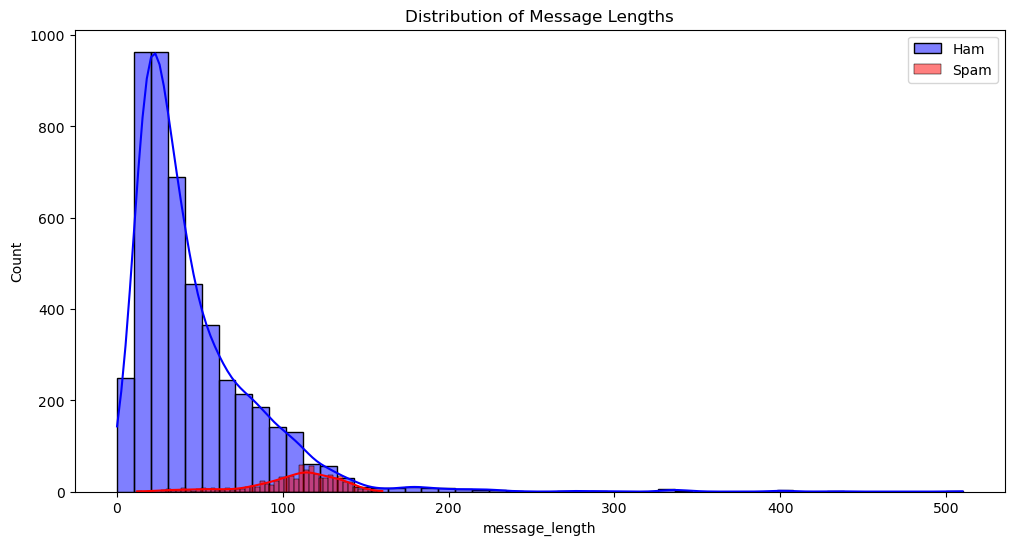

In [168]:
# Length of messages
df['message_length'] = df['message'].apply(len)

# Plot the distribution of message lengths
plt.figure(figsize=(12, 6))
sns.histplot(df[df['label'] == 'ham']['message_length'], bins=50, label='Ham', color='blue', kde=True)
sns.histplot(df[df['label'] == 'spam']['message_length'], bins=50, label='Spam', color='red', kde=True)
plt.legend()
plt.title('Distribution of Message Lengths')
plt.show()

### Evaluation of the model

In [173]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df['message'], df['label'], test_size=0.2, random_state=42)

In [174]:
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)  # Transform the training data
X_test_tfidf = vectorizer.transform(X_test)        # Transform the test data

In [175]:
model = MultinomialNB()
parameters = {'alpha': [0.1, 0.5, 1.0]}  # Example parameter grid

grid_search = GridSearchCV(model, param_grid=parameters, cv=5, scoring='accuracy')
grid_search.fit(X_train_tfidf, y_train)

# Best model from Grid Search
best_model = grid_search.best_estimator_

In [176]:
# Prediction
y_pred = best_model.predict(X_test_tfidf)

# Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")

Accuracy: 0.9811659192825112


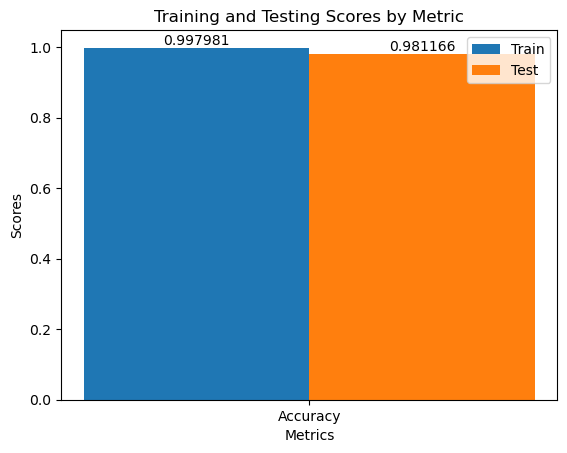

In [179]:
# Store metrics in a dictionary for easier plotting
metrics = {
    'Accuracy': [train_accuracy, test_accuracy],

}

# Plot the metrics
labels = list(metrics.keys())
train_scores = [metrics[metric][0] for metric in labels]
test_scores = [metrics[metric][1] for metric in labels]

x = range(len(labels))
bar_width = 0.3  # Width of the bars

fig, ax = plt.subplots()

ax.bar(train_bar_positions, train_scores, width=bar_width, label='Train')
ax.bar(test_bar_positions, test_scores, width=bar_width, label='Test')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Training and Testing Scores by Metric')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Add labels to each bar (using 'bar_label' function)
labels = plt.bar_label(plt.gca().containers[0])
labels = plt.bar_label(plt.gca().containers[1])

plt.show()
